# Téléchargement de la base de données

In [28]:
# Pour récupérer le nombre de classes du training dataset
from tensorflow import keras
from tensorflow.keras import layers

In [29]:
#!git clone https://github.com/fabiopereira59/abeilles-cap500

In [30]:
IMG_SIZE = 224
train_ds = keras.utils.image_dataset_from_directory(
    directory='/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/train_cropped/',
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(IMG_SIZE, IMG_SIZE))

Found 14539 files belonging to 71 classes.


In [31]:
class_names = train_ds.class_names
print(class_names)

['Amegilla quadrifasciata', 'Andrena agilissima', 'Andrena bicolor', 'Andrena cineraria', 'Andrena clarkella', 'Andrena denticulata', 'Andrena flavipes', 'Andrena florea', 'Andrena fulva', 'Andrena gravida', 'Andrena haemorrhoa', 'Andrena hattorfiana', 'Andrena nigroaenea', 'Andrena nitida', 'Andrena nycthemera', 'Andrena thoracica', 'Andrena vaga', 'Andrena ventralis', 'Anthidiellum strigatum', 'Anthidium florentinum', 'Anthidium manicatum', 'Anthidium oblongatum', 'Anthidium septemspinosum', 'Anthophora bimaculata', 'Anthophora furcata', 'Anthophora plumipes', 'Apis mellifera', 'Bombus argillaceus', 'Bombus bohemicus', 'Bombus campestris', 'Bombus hortorum', 'Bombus humilis', 'Bombus hypnorum', 'Bombus lapidarius', 'Bombus lucorum', 'Bombus muscorum', 'Bombus pascuorum', 'Bombus pratorum', 'Bombus ruderatus', 'Bombus rupestris', 'Bombus sylvarum', 'Bombus terrestris lusitanicus', 'Bombus vestalis', 'Ceratina cucurbitina', 'Chelostoma florisomne', 'Colletes cunicularius', 'Colletes he

In [32]:
nb_classes = len(class_names)
print(nb_classes)

71


# Chargement du modèle

In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

In [34]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
import tensorflow as tf

In [35]:
# Création de l'architecture du modèle à utiser

conv_base = keras.applications.resnet.ResNet101(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling=None,
    classes=nb_classes,
)

model = keras.Sequential(
    [
        conv_base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(nb_classes, kernel_regularizer=regularizers.L2(1e-4), activation='softmax')
    ]
)

# Chargement des poids
model.load_weights('/home/acarlier/Desktop/model_crop_well/model')#mettre ici le même chemin que celui des callbacks (dans la var model_checkpoints)

model.compile(optimizers.SGD(learning_rate=1e-3, momentum=0.9), loss='categorical_crossentropy', metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Chargement de l'ensemble de test

In [36]:
# Récupération du dataset de test
test_ds = keras.utils.image_dataset_from_directory(
    directory='/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped',
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(IMG_SIZE, IMG_SIZE))

Found 1773 files belonging to 71 classes.


In [37]:
test_ds_no_shuffle = keras.utils.image_dataset_from_directory(
    directory='/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    batch_size=16,
    image_size=(IMG_SIZE, IMG_SIZE))

Found 1773 files belonging to 71 classes.


In [38]:
import numpy as np

x_test = np.zeros((1832, IMG_SIZE, IMG_SIZE, 3))
y_test = np.zeros((1832, nb_classes))

ind_data = 0
for bx, by in test_ds_no_shuffle.as_numpy_iterator():
  x_test[ind_data:ind_data+bx.shape[0]] = bx
  y_test[ind_data:ind_data+bx.shape[0]] = by

  ind_data += bx.shape[0]

x_test = tf.keras.applications.resnet.preprocess_input(x_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped/Amegilla quadrifasciata/Amegilla quadrifasciata15848.jpeg


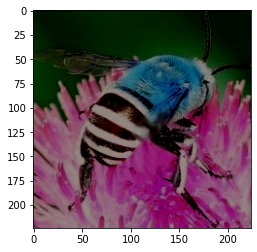

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from PIL import Image

plt.imshow(x_test[0].astype(int))
print(test_ds_no_shuffle.file_paths[0])

# Analyse des résultats : précision, sensibilité, F1_score

In [40]:
y_pred = model.predict(x_test)

In [41]:
import tensorflow
from tensorflow.keras.metrics import Accuracy

In [42]:
test_accuracy = Accuracy()

prediction = tensorflow.argmax(y_pred, axis=1, output_type=tensorflow.int32)
print(prediction)
test_accuracy(prediction, np.argmax(y_test, axis=1))

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

tf.Tensor([ 0  0  0 ... 26 26 26], shape=(1832,), dtype=int32)
Test set accuracy: 86.354%


In [43]:
test_topk_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top_k_categorical_accuracy", dtype=None)

test_topk_accuracy(y_test, y_pred)
print("Test set top 2 accuracy: {:.3%}".format(test_topk_accuracy.result()))

Test set top 2 accuracy: 93.450%


## Précision et Sensibilité

In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [45]:
true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(y_pred, axis=1)
#report = classification_report(true_labels, predicted_labels, target_names=class_names, digits=5)
report = classification_report(true_labels, predicted_labels, target_names=class_names, digits=5, output_dict=True)
print(report)

{'Amegilla quadrifasciata': {'precision': 0.8947368421052632, 'recall': 0.21794871794871795, 'f1-score': 0.3505154639175258, 'support': 78}, 'Andrena agilissima': {'precision': 0.9230769230769231, 'recall': 0.9230769230769231, 'f1-score': 0.9230769230769231, 'support': 13}, 'Andrena bicolor': {'precision': 1.0, 'recall': 0.3, 'f1-score': 0.4615384615384615, 'support': 10}, 'Andrena cineraria': {'precision': 0.9555555555555556, 'recall': 0.8958333333333334, 'f1-score': 0.924731182795699, 'support': 48}, 'Andrena clarkella': {'precision': 0.9523809523809523, 'recall': 0.8333333333333334, 'f1-score': 0.888888888888889, 'support': 24}, 'Andrena denticulata': {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 8}, 'Andrena flavipes': {'precision': 0.7368421052631579, 'recall': 0.6363636363636364, 'f1-score': 0.6829268292682926, 'support': 22}, 'Andrena florea': {'precision': 1.0, 'recall': 0.9047619047619048, 'f1-score': 0.9500000000000001, 'support': 21}, 'Andrena

In [46]:
import pandas as pd

In [47]:
df = pd.DataFrame(report).transpose()
display(df)
#path_report = "drive/MyDrive/Stage2A/cap500/ResNet101/ResNet101_Sequence/evaluation_by_species_resnet101_sequence_cap500.csv"
#df.to_csv(path_report)
cm = confusion_matrix(true_labels, predicted_labels)

,precision,recall,f1-score,support
Amegilla quadrifasciata,0.894737,0.217949,0.350515,78.000000
Andrena agilissima,0.923077,0.923077,0.923077,13.000000
Andrena bicolor,1.000000,0.300000,0.461538,10.000000
Andrena cineraria,0.955556,0.895833,0.924731,48.000000
Andrena clarkella,0.952381,0.833333,0.888889,24.000000
...,...,...,...,...
Xylocopa valga,0.777778,0.933333,0.848485,15.000000
Xylocopa violacea,1.000000,0.920000,0.958333,50.000000
accuracy,0.863537,0.863537,0.863537,0.863537
macro avg,0.860645,0.839526,0.838366,1832.000000


In [68]:
# Proportion de classes dont le f1_score est inférieur au f1_score moyen parmi 
# les classes dont le support est inférieur à un seui
df_without_average = df.head(nb_classes)
display(df_without_average)

averages = df.tail(3)
display(averages)

seuil = 15
selection = df_without_average.loc[df_without_average['support'] <= seuil]
display(selection)

nb_classes_under_represented = len(selection)

bad_f1_score = selection.loc[selection['f1-score'] <= averages.at['macro avg', 'f1-score']]
display(bad_f1_score)

nb_classes_bad_f1_score = len(bad_f1_score)
proportion = (nb_classes_bad_f1_score / nb_classes_under_represented) * 100
print("------- Proportion de : " + str(proportion) + " % -------")

,precision,recall,f1-score,support
Amegilla quadrifasciata,0.894737,0.217949,0.350515,78.0
Andrena agilissima,0.923077,0.923077,0.923077,13.0
Andrena bicolor,1.000000,0.300000,0.461538,10.0
Andrena cineraria,0.955556,0.895833,0.924731,48.0
Andrena clarkella,0.952381,0.833333,0.888889,24.0
...,...,...,...,...
Rhodanthidium septemdentatum,0.933333,0.823529,0.875000,17.0
Rhodanthidium sticticum,1.000000,1.000000,1.000000,14.0
Sphecodes albilabris,0.970588,0.970588,0.970588,34.0
Xylocopa valga,0.777778,0.933333,0.848485,15.0


,precision,recall,f1-score,support
accuracy,0.863537,0.863537,0.863537,0.863537
macro avg,0.860645,0.839526,0.838366,1832.000000
weighted avg,0.881493,0.863537,0.857484,1832.000000


,precision,recall,f1-score,support
Andrena agilissima,0.923077,0.923077,0.923077,13.0
Andrena bicolor,1.000000,0.300000,0.461538,10.0
Andrena denticulata,1.000000,0.750000,0.857143,8.0
Andrena gravida,0.666667,0.666667,0.666667,9.0
Andrena nycthemera,0.818182,0.818182,0.818182,11.0
Andrena thoracica,0.714286,0.714286,0.714286,7.0
Andrena ventralis,0.857143,0.923077,0.888889,13.0
Anthidiellum strigatum,0.846154,0.785714,0.814815,14.0
Anthidium oblongatum,0.833333,0.833333,0.833333,12.0
Anthidium septemspinosum,0.846154,0.846154,0.846154,13.0


,precision,recall,f1-score,support
Andrena bicolor,1.000000,0.300000,0.461538,10.0
Andrena gravida,0.666667,0.666667,0.666667,9.0
Andrena nycthemera,0.818182,0.818182,0.818182,11.0
Andrena thoracica,0.714286,0.714286,0.714286,7.0
Anthidiellum strigatum,0.846154,0.785714,0.814815,14.0
Anthidium oblongatum,0.833333,0.833333,0.833333,12.0
Anthophora furcata,0.571429,0.500000,0.533333,8.0
Bombus bohemicus,0.750000,0.600000,0.666667,15.0
Bombus muscorum,0.666667,1.000000,0.800000,6.0
Bombus ruderatus,0.666667,0.250000,0.363636,8.0


------- Proportion de : 57.14285714285714 % -------


# Analyse des confusions entre les classes

In [74]:
# fp et fn : on a une classe à prédire et on détecte une autre classe
# => la classe à prédire = fn et l'autre classe comptée en fp
# précision => proportion de bonne détection
# sensibilité => mesure de combien on en a manqué
def confused_class(class_num, confusion_matrix, threshold=0):
  """
  Obtenir la liste des classes avec laquelle on a confondu la classe indiquee
  par class_num (numero de la classe).

  Arguments :
  - class_num : le numero de la classe
  - confusion_matrix : la matrice de confusion

  Retourne :
  false_positives : un dictionnaire contenant les faux positifs
  """

  class_name = class_names[class_num]

  indices_fp = np.argwhere(confusion_matrix[class_num,:] >= threshold)
  indices_fp = indices_fp.flatten()

  #indices_fn = np.argwhere(confusion_matrix[:,class_num] >= threshold)
  #indices_fn = indices_fn.flatten()

  false_positives = {}
  for i in indices_fp:
    if i != class_num:
      false_positives[class_names[i]] = confusion_matrix[class_num, i]


  #false_negatives = {}
  #for i in indices_fn:
  #  if i != class_num:
  #    false_negatives[class_names[i]] = confusion_matrix[i,class_num]  

  return false_positives

In [75]:
def find_relevant_confusion(threshold, confusion_matrix):
  """
  Obtenir les classes avec lesquelles on a confondu l'entree du reseau.

  Arguments :
  - threshold : le nombre minimum de confusion avec une classe
  - confusion_matrix : la matrice de confusion des donnees

  Retourne :
  - dic_fp : un dictionnaire contenant : la classe "verite terrain" en clef, et
  en valeur, un dictionnaire contenant les classes avec lesquelles on a confondu
  la verite terrain (clef) et la nombre d'erreurs (valeur)
  """

  dic_fp = {}
  #dic_fn = {}

  for i in range(nb_classes):
    fp = confused_class(i, confusion_matrix, threshold=threshold)
    if (len(fp) > 0):
      dic_fp[class_names[i]] = fp
    #if (len(fn) > 0):
    #  dic_fn[class_names[i]] = fn
  return dic_fp

In [76]:
fp = confused_class(36, cm, 1)
print(fp)

TypeError: 'module' object is not subscriptable

In [52]:
import pprint
import pandas as pd
dic_fp = find_relevant_confusion(3, cm)
pprint.pprint(dic_fp, width=1)

dataframe = pd.DataFrame.from_dict(dic_fp)
#dataframe.to_csv("drive/MyDrive/Stage2A/resultats_confusion.csv")

{'Amegilla quadrifasciata': {'Apis mellifera': 59},
 'Andrena cineraria': {'Andrena vaga': 3},
 'Anthidium manicatum': {'Anthidium florentinum': 6},
 'Bombus bohemicus': {'Bombus vestalis': 4},
 'Bombus ruderatus': {'Bombus argillaceus': 3}}


# Affichage d'images mal classées

In [53]:
def get_misclassified_images(class_name, file_paths, y, y_pred):
  """
  Obtenir un dictionnaire des images mal classees ainsi que le label de la 
  classe avec laquelle on a fait la confusion.

  Arguments :
  - class_name : le nom de la classe souhaitée
  - x : les images d'entrees
  - y : les labels attendus
  - y_pred : les labels predits

  Retourne :
  - dic : un dictionnaire contenant en valeur le chemin de l'image mal classee
  et le label associe
  """

  num_class = class_names.index(class_name)
  index = np.where(y == num_class)

  dic = {}
  for i in index[0]:
    if (y_pred[i] != y[i]):
      dic[file_paths[i]] = class_names[y_pred[i]]
  
  return dic

In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as img
def print_misclassified_images(dic, class_name, bad_label):
  """
  Permet d'afficher au plus 9 images mal classees dont le label est
  bad_label.

  Arguments :
  - dic : un dictionnaire contenant en clef les chemins d'acces aux images mal
  classees et en valeur, le mauvais label associe
  """

  fig = plt.figure(figsize=(20, 20))
  keys = list(dic.keys())
  print
  rows = 3
  columns = 3

  j = 1
  for i in range(len(keys)):
    image_path = keys[i]
    if (dic[image_path] == bad_label):
      fig.add_subplot(rows, columns, j)
      image = img.imread(image_path)
      plt.imshow(image)
      plt.axis('off') 
      plt.title("Attendu : " + class_name + " / Prédit : " + dic[image_path])
      j += 1
    if j == 9:
      break;

{'/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped/Andrena clarkella/Andrena clarkella24935.jpg': 'Andrena '
                                                                                                                         'nycthemera',
 '/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped/Andrena clarkella/Andrena clarkella29268.jpg': 'Andrena '
                                                                                                                         'thoracica',
 '/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped/Andrena clarkella/Andrena clarkella55642.jpg': 'Andrena '
                                                                                                                         'nycthemera',
 '/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped/Andrena clarkella/andrena_m.jpg': 'Colletes '
                                                                                

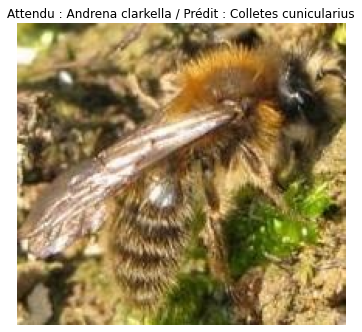

In [55]:
true_y = np.argmax(y_test, axis=1)
predicted_y = np.argmax(y_pred, axis=1)
file_paths = test_ds_no_shuffle.file_paths
class_name = "Andrena clarkella"
mauvais_label = "Colletes cunicularius"

dic = get_misclassified_images(class_name, file_paths, true_y, predicted_y)
pprint.pprint(dic, width=1)
print_misclassified_images(dic, class_name, mauvais_label)

# Affichage d'heatmaps d'images mal classées - Méthode Grad-CAM

## Définition des fonctions pour les heatmaps



In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 71)                145479    
                                                                 
Total params: 42,803,655
Trainable params: 42,698,311
Non-trainable params: 105,344
_________________________________________________________________


In [57]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [58]:
last_conv_layer_name = "resnet101"

# The local path to our target image
#img_path = "abeilles-cap500/test/Amegilla quadrifasciata/LMDI_amegilla.jpg"

#display(Image(img_path))

In [59]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer("global_average_pooling2d").input, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [60]:
# Prepare image
#img_array = tf.keras.applications.resnet.preprocess_input(get_img_array(img_path, size=(IMG_SIZE,IMG_SIZE)))

# Remove last layer's softmax
#model.layers[-1].activation = None


# Generate class activation heatmap
#heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
#plt.matshow(heatmap)
#plt.show()

In [61]:
from scipy import ndimage, misc
def save_and_display_gradcam(img_path, heatmap, cam_path="/content/drive/MyDrive/img.jpg", alpha=0.4, seuil_heatmap=0, affichage_contour=True, affichage_heatmap=False):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.where(heatmap > seuil_heatmap, heatmap, 0)
    #print("heatmap")
    #print(heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    #print("jeat_heatmap")
    #print(jet_heatmap)

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    #print(jet_heatmap)
    superimposed_img = np.copy(img)
    red = np.zeros((IMG_SIZE, IMG_SIZE))
    for i in range(IMG_SIZE):
      for j in range(IMG_SIZE):
        # Partie la plus chaude de la heatmap
        if (not(affichage_heatmap)):
          if (jet_heatmap[i][j][0] > seuil_heatmap):
            superimposed_img[i][j] = jet_heatmap[i][j] * alpha + img[i][j]
            red[i][j] = 1
        else:
          superimposed_img[i][j] = jet_heatmap[i][j] * alpha + img[i][j]
          red[i][j] = 1
    
    # Affichage uniquement du contour
    if (affichage_contour):
      contour = np.copy(img)
      for i in range(1, IMG_SIZE-1):
        for j in range(1, IMG_SIZE-1):
          if (red[i][j] == 1):
            sub_red = red[i-1:i+2, j-1:j+2]
            nb_ones = np.sum(sub_red)
            if (nb_ones <= 6):
              contour[i][j] = superimposed_img[i][j]
      superimposed_img = contour

    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    return superimposed_img

#save_and_display_gradcam(img_path, heatmap)

## Affichage des heatmaps sur des images mal classées

In [62]:
import matplotlib.pyplot as plt
import matplotlib.image as img
def print_misclassified_images_heatmaps(dic, class_name, bad_label, alpha=1.2, seuil_heatmap=0, affichage_contour=True, affichage_heatmap=False):
  """
  Permet d'afficher au plus 9 heatmaps d'images mal classees dont le label est
  bad_label.

  Arguments :
  - dic : un dictionnaire contenant en clef les chemins d'acces aux images mal
  classees et en valeur, le mauvais label associe
  """

  fig = plt.figure(figsize=(20, 20))
  keys = list(dic.keys())
  print
  rows = 3
  columns = 3

  j = 1
  for i in range(len(keys)):
    image_path = keys[i]
    if (dic[image_path] == bad_label):
      fig.add_subplot(rows, columns, j)
      image_array = tf.keras.applications.resnet.preprocess_input(get_img_array(image_path, size=(IMG_SIZE,IMG_SIZE)))
      heatmap = make_gradcam_heatmap(image_array, model, last_conv_layer_name)
      superimposed_img = save_and_display_gradcam(image_path, heatmap, alpha=alpha, seuil_heatmap=seuil_heatmap, affichage_contour=affichage_contour, affichage_heatmap=affichage_heatmap)
      plt.imshow(superimposed_img)
      plt.axis('off') 
      plt.title("Attendu : " + class_name + " / Prédit : " + dic[image_path])
      j += 1
    if j == 9:
      break;

In [63]:
# Remove last layer's softmax
model.layers[-1].activation = None

class_name = "Bombus lucorum"
mauvais_label = "Bombus vestalis"
dic = get_misclassified_images(class_name, file_paths, true_y, predicted_y)
#pprint.pprint(dic, width=1)

print_misclassified_images_heatmaps(dic, class_name, mauvais_label, seuil_heatmap=0, affichage_contour=False, affichage_heatmap=True)

<Figure size 1440x1440 with 0 Axes>

In [64]:
class_name = "Bombus lucorum"
mauvais_label = "Bombus vestalis"
dic = get_misclassified_images(class_name, file_paths, true_y, predicted_y)
#pprint.pprint(dic, width=1)

print_misclassified_images_heatmaps(dic, class_name, mauvais_label, seuil_heatmap=200, affichage_contour=True, affichage_heatmap=False)

<Figure size 1440x1440 with 0 Axes>

# Affichage des heatmaps sur des images bien classées

In [65]:
def get_classified_images(class_name, file_paths, y, y_pred):
  num_class = class_names.index(class_name)
  index = np.where(y == num_class)

  dic = {}
  for i in index[0]:
    if (y_pred[i] == y[i]):
      dic[file_paths[i]] = class_names[y_pred[i]]
  
  return dic

In [66]:
class_name = "Bombus humilis"
dic_apis_mellifera = get_classified_images(class_name, file_paths, true_y, predicted_y)
print(dic_apis_mellifera)

{'/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped/Bombus humilis/Bombus humilis13166.jpeg': 'Bombus humilis', '/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped/Bombus humilis/Bombus humilis1623.jpeg': 'Bombus humilis', '/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped/Bombus humilis/Bombus humilis34963.jpg': 'Bombus humilis', '/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped/Bombus humilis/Bombus humilis56058.jpg': 'Bombus humilis', '/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped/Bombus humilis/Bombus humilis62714.jpeg': 'Bombus humilis', '/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped/Bombus humilis/Bombus humilis68982.jpeg': 'Bombus humilis', '/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped/Bombus humilis/Bombus humilis73949.jpg': 'Bombus humilis', '/home/acarlier/code/projet_abeilles/abeilles-cap500/cap500/test_cropped

ValueError: No such layer: global_average_pooling2d. Existing layers are: ['resnet101', 'global_average_pooling2d_1', 'dense_1'].

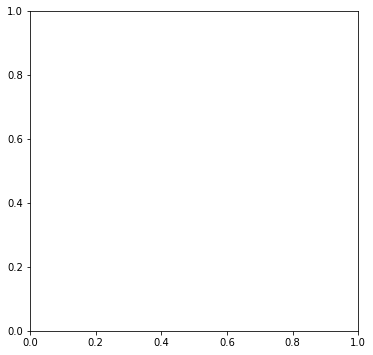

In [67]:
print_misclassified_images_heatmaps(dic_apis_mellifera, class_name, class_name, seuil_heatmap=200, affichage_contour=True, affichage_heatmap=False)

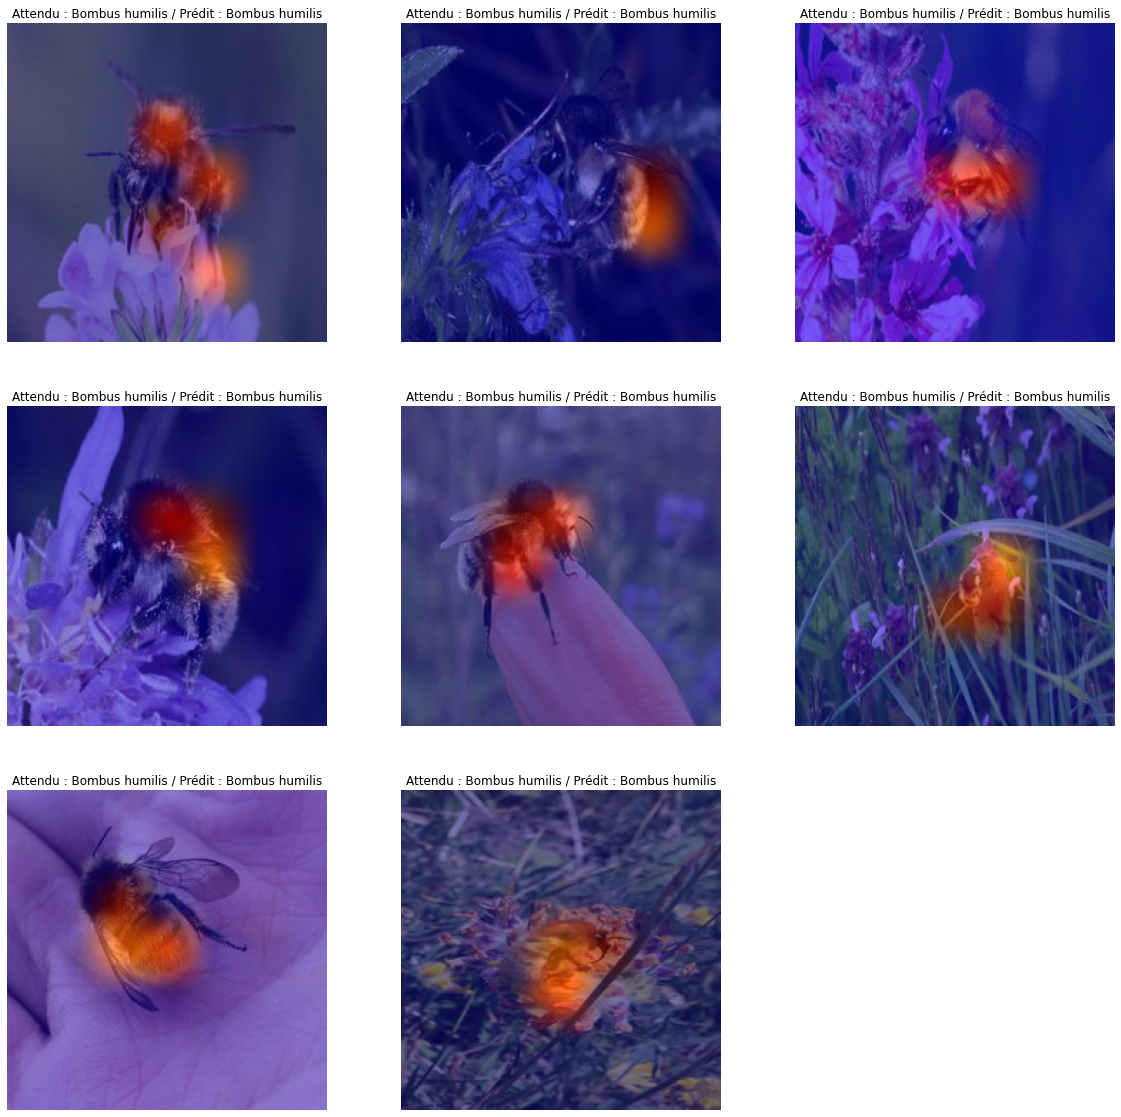

In [ ]:
print_misclassified_images_heatmaps(dic_apis_mellifera, class_name, class_name, seuil_heatmap=200, affichage_contour=False, affichage_heatmap=True)

# Sauvegarde des heatmaps des images de l'ensemble de test

In [ ]:
true_y.shape[0]
print(true_y)

[ 0  0  0 ... 70 70 70]


In [ ]:
import numpy as np
import os
from PIL import Image
path = os.getcwd()
path = path + "/drive/MyDrive/Stage2A/cap500/ResNet101/ResNet101_Sequence/TestHeatmaps"
print(path)

/content/drive/MyDrive/Stage2A/cap500/ResNet101/ResNet101_Sequence/TestHeatmaps


In [ ]:
len(class_names)

71

In [ ]:
def create_directory(directory_path, class_names):
  
  nb_especes = len(class_names)

  for i in range(nb_especes):
    species = class_names[i]
    os.mkdir(directory_path + "/" + species)
    os.mkdir(directory_path + "/" + species + "/images_bien_classees")
    os.mkdir(directory_path + "/" + species + "/images_bien_classees" + "/heatmaps")
    os.mkdir(directory_path + "/" + species + "/images_bien_classees" + "/contours200")
    os.mkdir(directory_path + "/" + species + "/images_bien_classees" + "/contours220")
    os.mkdir(directory_path + "/" + species + "/images_mal_classees")
    os.mkdir(directory_path + "/" + species + "/images_mal_classees" + "/heatmaps")
    os.mkdir(directory_path + "/" + species + "/images_mal_classees" + "/contours200")
    os.mkdir(directory_path + "/" + species + "/images_mal_classees" + "/contours220")

In [ ]:
create_directory(path, class_names)

In [ ]:
file_paths[0]

'abeilles-cap500/test/Amegilla quadrifasciata/Amegilla quadrifasciata15848.jpeg'

In [ ]:
def save_heatmaps(class_names, file_paths, y, y_pred):

  nb_images = y.shape[0]

  for i in range(nb_images):

    species = class_names[y[i]]
    image_path = file_paths[i]
    image_name = os.path.basename(image_path)
    image_array = tf.keras.applications.resnet.preprocess_input(get_img_array(image_path, size=(IMG_SIZE,IMG_SIZE)))
    heatmap = make_gradcam_heatmap(image_array, model, last_conv_layer_name)
    # Calcul heatmap
    heatmap_image = save_and_display_gradcam(image_path, heatmap, alpha=1.2, seuil_heatmap=200, affichage_contour=False, affichage_heatmap=True)
    # Calcul contour
    contour_image200 = save_and_display_gradcam(image_path, heatmap, alpha=1.2, seuil_heatmap=200, affichage_contour=True, affichage_heatmap=False)
    contour_image220 = save_and_display_gradcam(image_path, heatmap, alpha=1.2, seuil_heatmap=220, affichage_contour=True, affichage_heatmap=False)
    if (y[i] == y_pred[i]):
      name_to_save = path + "/" + species + "/" + "images_bien_classees"
      #print(name_to_save)
      heatmap_image.save(name_to_save + "/" + "heatmaps" + "/" + "heatmap_" + image_name)
      contour_image200.save(name_to_save + "/" + "contours200" + "/" + "contour200_" + image_name)
      contour_image220.save(name_to_save + "/" + "contours220" + "/" + "contour220_" + image_name)
    else:
      name_to_save = path + "/" + species + "/" + "images_mal_classees"
      bad_species = class_names[y_pred[i]]
      #print(name_to_save)
      #print(bad_species)
      heatmap_image.save(name_to_save + "/" + "heatmaps" + "/" + "heatmap_predit_" + bad_species + "_" + image_name)
      contour_image200.save(name_to_save + "/" + "contours200" + "/" + "contour200_predit_" + bad_species + "_" + image_name)
      contour_image220.save(name_to_save + "/" + "contours220" + "/" + "contour220_predit_" + bad_species + "_" + image_name)

In [ ]:
save_heatmaps(class_names, file_paths, true_y, predicted_y)